# Theoretical Questions

** Задача 1. **
Решается задача кластеризации N объектов двумя алгоритмами: KMeans и EM. Оба алгоритма выдают три кластера, центры кластеров в обоих случаях совпадают. Могут ли 3 разные точки исходной выборки, которые отнесены KMeans к трем разным класетрам, быть отнесены к одному кластеру согласно EM-алгоритму? Ответ обосновать.  
** Ответ: ** 
![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/ClusterAnalysis_Mouse.svg/1355px-ClusterAnalysis_Mouse.svg.png)
Классический пример, когда KMeans и EM работают по разному. Все происходит так, потому что KMeans смотрит на расстояния (все решает метрика), а EM ориентируется на распределения.

** Задача 2. **
Даны шесть точек на числовой оси $X = (0, 7, 3, 7, 8, 2)$, число кластеров равно 2. Рассчитайте ответ алгоритма  KMeans (финальные центры кластеров), если начальные центры кластеров $c_{1} = 0$, $c_{2} = 10$.  
** Решение: ** На первой итерации точки 0, 2 и 3 будут отнесены к первому классу, а 7, 7 и 8 - ко второму. После пересчета центры расположатся в точках

$$c_{1} = \dfrac{0 + 2 + 3}{3} = \dfrac{5}{3}$$

$$c_{2} = \dfrac{7 + 7 + 8}{3} = \dfrac{22}{3}$$

Осталось заметить, что алгоритм сошелся --- точки уже не изменят своих классов.

** Задача 3. **
Докажите, что the KMeans всегда сходится.  
** Доказательство: ** Во-первых, существует не более $k^{N}$ способов распределить $N$ точек по $k$ кластерам, то есть существует лишь конечное число возможных вариантов. Дальше отметим, что каждая следующая итерация алгоритма зависит только от предыдущей. Теперь поймем следующее: если на $i + 1$ итерации алгоритма получилась та же кластеризация, что и на $i$ итерации, то дальнейшие кластеризации будут давать ту же самую кластеризацию, а если $i + 1$ кластеризация отличается от $i$, то первая имеет меньшую функцию потерь.  
Предположим противное: допустим, что KMeans не сходится. Тогда получается, что алгоритм бесконечно итерируется по конечному набору состояний. Следовательно, в какой-то момент образуется цикл. Выше было сказано, что если $i+1$ состояние отличается от $i$, то произошло уменьшение функции потерь. Но тогда приходим к следующему противоречию: из некоторого состояния $i_{0}$ мы попали обратно в него же (при этом пройдя другие состояния), но с меньшим значением функции потерь. Значит, наше предположение неверно, и KMeans сходится.

** Задача 4. **
Для сжатия размерности пространства алгоритм PCA применяется датасету с количеством признаков $D = 100$. Наблюдается следующий спектр собственных значений матрицы объектов-признаков. 
![](https://raw.githubusercontent.com/ml-mipt/ml-mipt-part1/master/2018/hw/hw9/PCA_lambda.PNG)  
Ответье на вопросы:
1. Высокая ли эффективная размерность пространства признаков (intrinsic dimensionality)? Насколько она близка к 100?
2. Можно ли перевести датасет с помощью PCA в пространство меньшей размерности с минимальными потерями точности? Если да, то чему примерно будет равна размернось.  

** Ответ: **  
1. График собственных значений похож на прямую $\implies$ эффективная размерность пространства высокая (разница между максимумом и минимумом не велика, все признаки считаются важными). Таким образом, размерность находится близко к 100.
2. Как было сказано выше, все признаки считаются важными $\implies$ если обрезать так, чтобы осталось 80-90% данных, то останется 80-90 признаков, то есть PCA не подходит для того, чтобы снизить размерность.

# Practice

In [1]:
# ! pip install imageio

import numpy as np
from imageio import imread

from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from skimage.measure import compare_ssim
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Image Compression with Singular Value Decomposition

*First, let's download the image.*

In [2]:
IMAGE_PATH = 'http://wallpaperswide.com/download/under_a_yellow_tree-wallpaper-1920x1080.jpg'
image = imread(IMAGE_PATH)
print('Image shape: {}'.format(image.shape))

Image shape: (1080, 1920, 3)


*Now we need to write some useful functions.*

In [0]:
def slice(shape, scale=1):
    return ((shape[0] * shape[1]) // scale) // (shape[0] + shape[0] + 1)

In [0]:
def compress_matrix(matrix, scale=1):
    # Build matricies
    u, s, v = np.linalg.svd(matrix)
    s = np.diag(s)
    
    # Prepare data
    k = slice(matrix.shape, scale)
    u = u[:, :k]
    s = s[:k, :k]
    v = v[:k, :]
    
    # Compress image
    comressed_matrix = u @ s @ v
    return comressed_matrix

In [0]:
def compress_image(image, scale=1):
    # Compress each color
    red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    red = compress_matrix(red, scale)
    green = compress_matrix(green, scale)
    blue = compress_matrix(blue, scale)
    
    # Fix output of SVD-compressing
    red = np.clip(red, 0, 255)
    green = np.clip(green, 0, 255)
    blue = np.clip(blue, 0, 255)
    
    # Build image back
    compressed_image = np.dstack((red, np.dstack((green, blue))))
    
    # Don't forget to cast to uint8
    return compressed_image.astype(np.uint8)

*Let's check the results!*

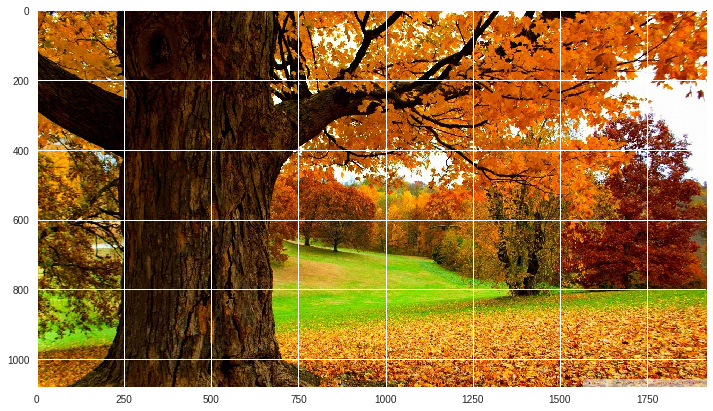

In [6]:
plt.figure(figsize=(12,8))
plt.imshow(compress_image(image, 1))
plt.show()

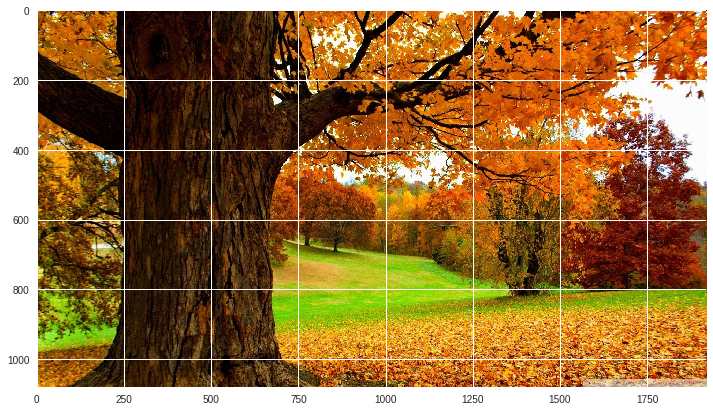

In [7]:
plt.figure(figsize=(12,8))
plt.imshow(compress_image(image, 2))
plt.show()

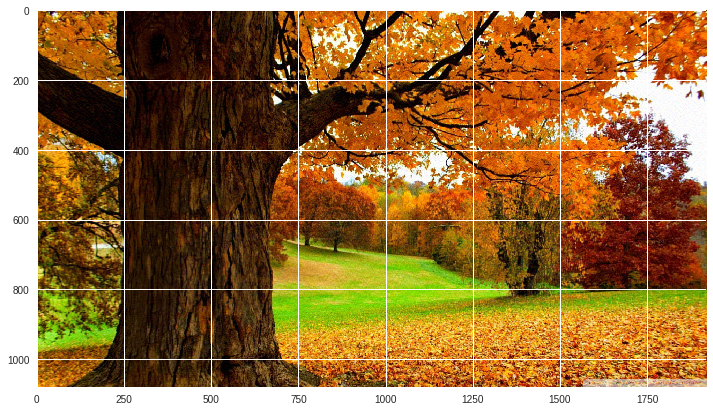

In [8]:
plt.figure(figsize=(12,8))
plt.imshow(compress_image(image, 4))
plt.show()

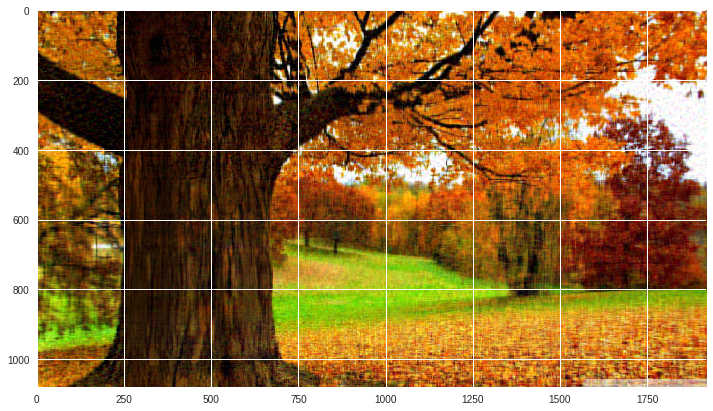

In [9]:
plt.figure(figsize=(12,8))
plt.imshow(compress_image(image, 16))
plt.show()

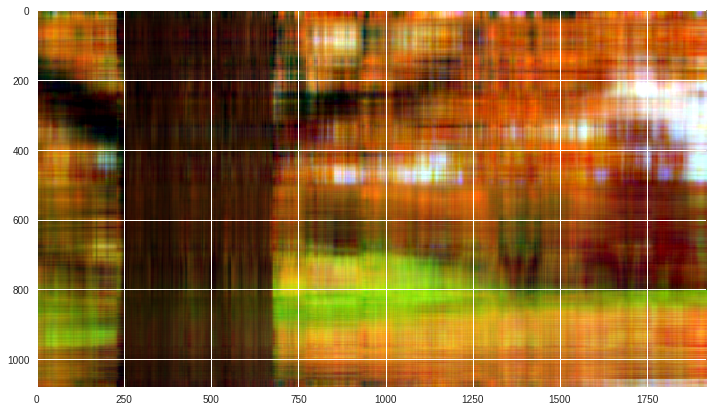

In [10]:
plt.figure(figsize=(12,8))
plt.imshow(compress_image(image, 128))
plt.show()

*Everything is OK!*

## Study of clustering algorithms on different samples

*First, let's download the image.*

In [11]:
IMAGE_PATH = 'https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'
image = imread(IMAGE_PATH)
print('Image shape: {}'.format(image.shape))

Image shape: (275, 400, 3)


*Now we need to prepare it for further usage.*

In [0]:
# Compress image, because it's to big for clustering algorithms
image = image[::4, ::4, :]

# Save shape as we'll need it later to redraw images
shape = image.shape
image = image.reshape(-1, 3)

*Let's write some functions to ease our work.*

In [0]:
def show_results(images):
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    for i, image in enumerate(images):
        plt.subplot(2, 2, i+1)
        plt.imshow(image)

In [0]:
def kmeans_clustering(image, shape):
    images = []
    for n in [2, 3, 10, 20]:
        kmeans = KMeans(n_clusters=n, random_state=42).fit(image)
        
        print('Clustering with KMeans for {} clusters...'.format(n))
        print('Labels example: {}'.format(kmeans.labels_[:10]))
        print('Cluster centers: {}\n\n'.format(kmeans.cluster_centers_))
        
        # Perform clustering
        tmp = np.array(list(image))
        for i in range(tmp.shape[0]):
            tmp[i] = kmeans.cluster_centers_[kmeans.labels_[i]]
        
        # Build image back
        tmp = tmp.reshape(shape)
        images += [tmp]
    return images

In [0]:
def meanshift_clustering(image, shape):
    images = []
    for n in [80, 75, 50, 39.25]:
        # Sine MeanShift works with bandwidth instead of clusters
        # we need to find the relation between them by ourselfs
        # After brute force search I found these numbers
        meanshift = MeanShift(bandwidth=n).fit(image)
        
        print('Clustering with MeanShift for {} clusters...'.format(n))
        print('Labels example: {}'.format(meanshift.labels_[:10]))
        print('Cluster centers: {}\n\n'.format(meanshift.cluster_centers_))
        
        # Perform clustering
        tmp = np.array(list(image))
        for i in range(tmp.shape[0]):
            tmp[i] = meanshift.cluster_centers_[meanshift.labels_[i]]
        
        # Build image back
        tmp = tmp.reshape(shape)
        images += [tmp]
    return images

In [0]:
def agglomerative_clustering(image, shape):
    images = []
    for n in [2, 3, 10, 20]:
        agcl = AgglomerativeClustering(n_clusters=n).fit(image)
        
        # Find clusters centers
        centers = []
        for i in range(n):
            centers += [list(np.mean(image[agcl.labels_ == i], axis=0))]
        centers = np.array(centers)
        
        print('Clustering with AgglomerativeClustering for {} clusters...'
              .format(n))
        print('Labels example: {}'.format(agcl.labels_[:10]))
        print('Cluster centers: {}\n\n'.format(centers))
        
        # Perform clustering
        tmp = np.array(list(image))
        for i in range(tmp.shape[0]):
            tmp[i] = centers[agcl.labels_[i]]
        
        # Build image back
        tmp = tmp.reshape(shape)
        images += [tmp]
    return images

*Let's reduce image's palette using different approaches.*

In [17]:
kmeans = kmeans_clustering(image, shape)

Clustering with KMeans for 2 clusters...
Labels example: [1 1 1 1 1 1 1 1 1 1]
Cluster centers: [[ 64.29621543  62.18777293  63.41885007]
 [169.74132948 151.64041426  96.21700385]]


Clustering with KMeans for 3 clusters...
Labels example: [1 1 1 1 1 1 1 1 1 1]
Cluster centers: [[ 58.77650551  56.24597116  55.13401187]
 [141.71424187 145.82412523 124.18017188]
 [218.96573209 150.14018692  30.51635514]]


Clustering with KMeans for 10 clusters...
Labels example: [7 1 1 1 1 7 7 7 7 7]
Cluster centers: [[154.76       176.075      222.475     ]
 [125.08901651 123.36826992  94.8327351 ]
 [ 21.41677096  20.39549437  23.35294118]
 [248.01890756 197.59033613  25.31092437]
 [151.21921182  53.91625616  16.81034483]
 [ 36.0477327   73.75178998 159.38186158]
 [231.52359551 104.8494382   46.96629213]
 [162.35124509 162.91480996 133.98754915]
 [ 77.86716259  83.03400638  64.49096706]
 [137.40338983 192.86101695  23.07457627]]


Clustering with KMeans for 20 clusters...
Labels example: [16 16 16 16 1

In [18]:
meanshift = meanshift_clustering(image, shape)

Clustering with MeanShift for 80 clusters...
Labels example: [0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[137.79308196 136.55905266 110.48208165]
 [243.77688604 179.18138042  23.59390048]]


Clustering with MeanShift for 75 clusters...
Labels example: [0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[139.96759259 138.50793651 112.13029101]
 [ 40.43265613  39.26636569  37.56433409]
 [227.55271084 118.35843373  35.17620482]]


Clustering with MeanShift for 50 clusters...
Labels example: [0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[151.87341772 149.9443038  119.99696203]
 [ 13.91559633  12.23119266  14.55412844]
 [248.91794872 192.31025641  14.8       ]
 [154.42105263  64.04934211  20.34868421]
 [236.26666667 109.55        31.39666667]
 [106.33333333  47.30902778  22.10416667]
 [125.38323353 179.2754491   17.32934132]
 [ 99.30973451 124.37168142 184.99115044]
 [173.7752809  187.52808989 229.        ]
 [213.76785714 238.76785714 115.125     ]]


Clustering with MeanShift for 39.25 clusters...
Labels exampl

In [19]:
agcl = agglomerative_clustering(image, shape)

Clustering with AgglomerativeClustering for 2 clusters...
Labels example: [0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[147.37881696 131.91729192  92.63252486]
 [ 31.50042772  38.05389222  36.69033362]]


Clustering with AgglomerativeClustering for 3 clusters...
Labels example: [0 0 0 0 0 0 0 0 0 0]
Cluster centers: [[130.04515464 127.50247423 102.5814433 ]
 [ 31.50042772  38.05389222  36.69033362]
 [242.80249716 156.22133939  37.86265607]]


Clustering with AgglomerativeClustering for 10 clusters...
Labels example: [8 8 8 8 8 8 0 0 0 0]
Cluster centers: [[163.91161432 166.6311176  150.99342586]
 [ 41.41190476  51.13571429  48.45      ]
 [147.58680556  60.54166667  22.765625  ]
 [129.11270983 179.1942446   36.76498801]
 [ 46.43073048  85.50377834 170.44332494]
 [237.57983193 116.74369748  49.61554622]
 [ 99.98714653  99.37960583  87.28363325]
 [248.94074074 202.61975309  24.04938272]
 [143.24242424 141.50649351 100.47619048]
 [  6.19452888   4.65349544   6.6656535 ]]


Clustering with Agglo

*Let's see the results!*

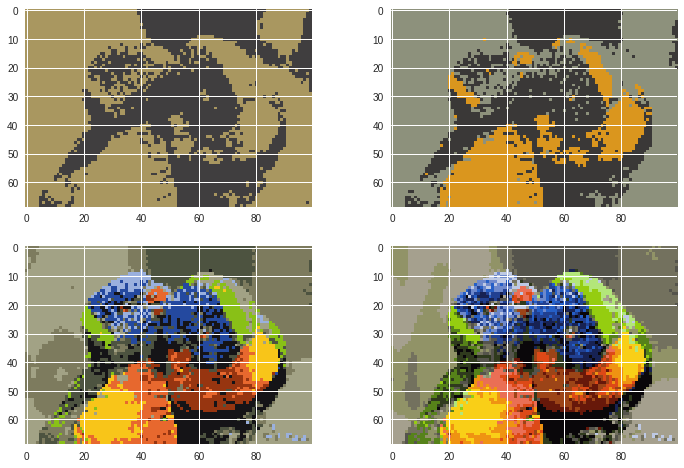

In [20]:
show_results(kmeans)

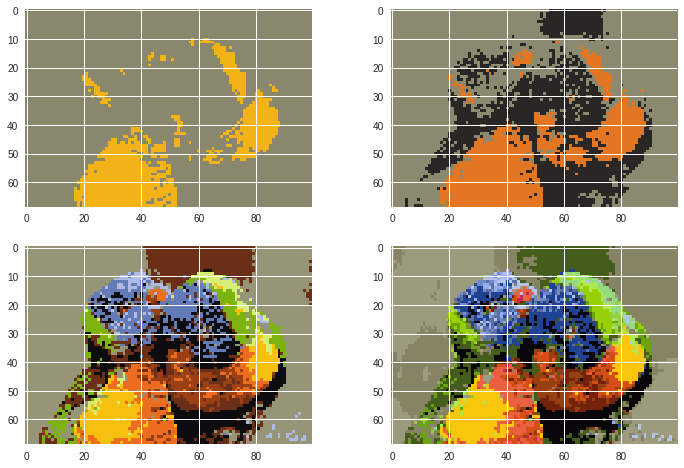

In [21]:
show_results(meanshift)

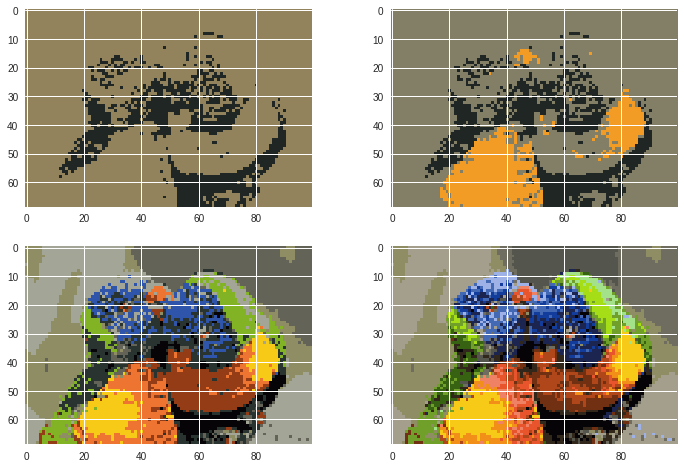

In [22]:
show_results(agcl)

*Let's find out which algorithm is better!*

In [23]:
for algorithm, images in zip(['KMeans', 'MeanShift', 'AgglomerativeClustering'],
                             [kmeans, meanshift, agcl]):
    print(algorithm)
    for i, clusters_count in enumerate([2, 3, 10, 20]):
        print('  {:2} clusters  =>  similarity = {:.3}'
              .format(clusters_count, compare_ssim(image.reshape(shape),
                                                   images[i], win_size=3)))

KMeans
   2 clusters  =>  similarity = 0.474
   3 clusters  =>  similarity = 0.586
  10 clusters  =>  similarity = 0.809
  20 clusters  =>  similarity = 0.879
MeanShift
   2 clusters  =>  similarity = 0.487
   3 clusters  =>  similarity = 0.617
  10 clusters  =>  similarity = 0.76
  20 clusters  =>  similarity = 0.823
AgglomerativeClustering
   2 clusters  =>  similarity = 0.477
   3 clusters  =>  similarity = 0.578
  10 clusters  =>  similarity = 0.794
  20 clusters  =>  similarity = 0.87


*So the best options are:*
- 2 clusters --- MeanShift
- 3 clusters --- MeanShift
- 10 clusters --- KMeans
- 20 clusters --- KMeans

## Autoencoder

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification.
![](https://multithreaded.stitchfix.com/assets/images/blog/PS_NN_graphic_colors2.png)

Now implement an autoencoder.  
Build it such that dimetionality inside autoencoder changes like that: 
$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$
Use **MSECriterion** to score the reconstruction.  
You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

*First, let's get the data.*

In [0]:
# Get data
mnist = fetch_mldata('MNIST original')

# Split
data = mnist.data
target = mnist.target

# Normalization
data = data / 255.

*Now we need to onehot it.*

In [0]:
y = np.zeros((target.shape[0],10))
for i in range(target.shape[0]):
    y[i, int(target[i])] = 1

*It's time to create samples.*

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

*Let's write our architecture.*

In [0]:
default = Sequential()
default.add(Dense(512, input_shape=(784,), activation='relu'))
default.add(Dense(256, activation='relu'))
default.add(Dense(128, activation='relu'))
default.add(Dense(30, activation='relu'))
default.add(Dense(128, activation='relu'))
default.add(Dense(256, activation='relu'))
default.add(Dense(512, activation='relu'))
default.add(Dense(784, activation='relu'))

default.compile(loss=losses.mean_squared_error, optimizer=Adam(lr=0.01))

In [28]:
default.fit(x=X_train, y=X_train, batch_size=256,
            epochs=10, validation_data=(X_test, X_test))

Train on 46900 samples, validate on 23100 samples
Epoch 1/10
46900/46900 [==============================] - 4s 84us/step - loss: 0.0854 - val_loss: 0.0466
Epoch 2/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0392 - val_loss: 0.0348
Epoch 3/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0325 - val_loss: 0.0312
Epoch 4/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0301 - val_loss: 0.0295
Epoch 5/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0284 - val_loss: 0.0277
Epoch 6/10
46592/46900 [============================>.] - ETA: 0s - loss: 0.0265

46900/46900 [==============================] - 3s 56us/step - loss: 0.0265 - val_loss: 0.0265
Epoch 7/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0254 - val_loss: 0.0250
Epoch 8/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0246 - val_loss: 0.0250
Epoch 9/10
46900/46900 [==============================] - 3s 55us/step - loss: 0.0236 - val_loss: 0.0238
Epoch 10/10
46900/46900 [==============================] - 3s 56us/step - loss: 0.0232 - val_loss: 0.0236


In [0]:
auto_pred = default.predict(X_test)

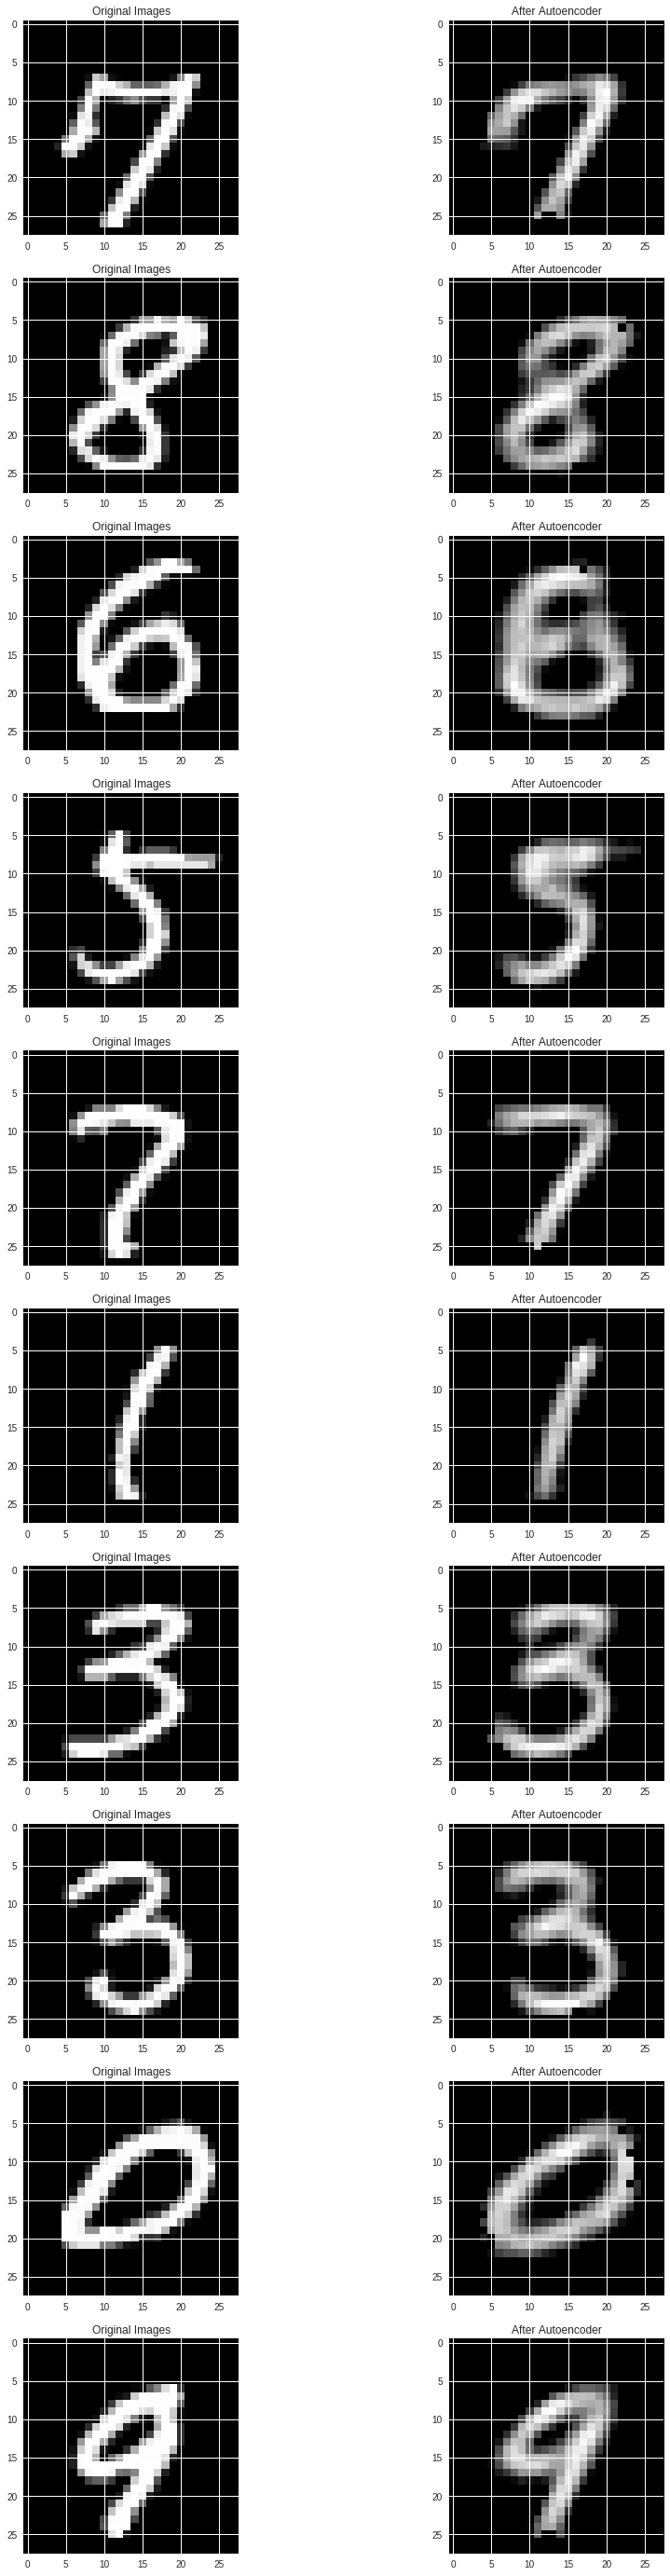

In [30]:
fig, ax = plt.subplots(10, 2, figsize=(15, 50))
for i in range(10):
    ax[i][0].set_title('Original Images')
    ax[i][0].imshow(X_test[i].reshape((28, 28)), cmap='gray')
    ax[i][1].set_title('After Autoencoder')
    ax[i][1].imshow(auto_pred[i].reshape((28, 28)), cmap='gray')

*Autoencoded numbers are easily recognisable.*

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [0]:
custom = Sequential(layers=default.layers[:4])
custom.add(Dense(10, activation='softmax'))

custom.compile(loss=losses.categorical_crossentropy,
                optimizer=Adam(lr=0.001),
                metrics=['accuracy'])

In [32]:
custom.fit(x=X_train, y=y_train, batch_size=256,
           epochs=10, validation_data=(X_test, y_test))

Train on 46900 samples, validate on 23100 samples
Epoch 1/10
46900/46900 [==============================] - 2s 49us/step - loss: 1.1527 - acc: 0.6182 - val_loss: 0.3557 - val_acc: 0.8993
Epoch 2/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.2748 - acc: 0.9214 - val_loss: 0.2268 - val_acc: 0.9337
Epoch 3/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.1977 - acc: 0.9432 - val_loss: 0.1840 - val_acc: 0.9455
Epoch 4/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.1640 - acc: 0.9522 - val_loss: 0.1642 - val_acc: 0.9513
Epoch 5/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.1408 - acc: 0.9589 - val_loss: 0.1463 - val_acc: 0.9568
Epoch 6/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.1241 - acc: 0.9635 - val_loss: 0.1404 - val_acc: 0.9582
Epoch 7/10
 3072/46900 [>.............................] - ETA: 1s - loss: 0.1054 - acc: 0.9684

46900/46900 [==============================] - 2s 43us/step - loss: 0.1118 - acc: 0.9672 - val_loss: 0.1279 - val_acc: 0.9622
Epoch 8/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.1030 - acc: 0.9697 - val_loss: 0.1263 - val_acc: 0.9634
Epoch 9/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.0945 - acc: 0.9719 - val_loss: 0.1193 - val_acc: 0.9653
Epoch 10/10
46900/46900 [==============================] - 2s 43us/step - loss: 0.0870 - acc: 0.9741 - val_loss: 0.1236 - val_acc: 0.9633


*We see, that's everything is cool!*  
*The method seems odd, but it gives good results. So I think it could be useful.*

Run PCA with 30 components on the train set, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from validation set.

In [0]:
pca = PCA(n_components=30)

In [34]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_pred = pca.inverse_transform(pca.transform(X_test))
pca_pred = np.clip(pca_pred, 0, 1)

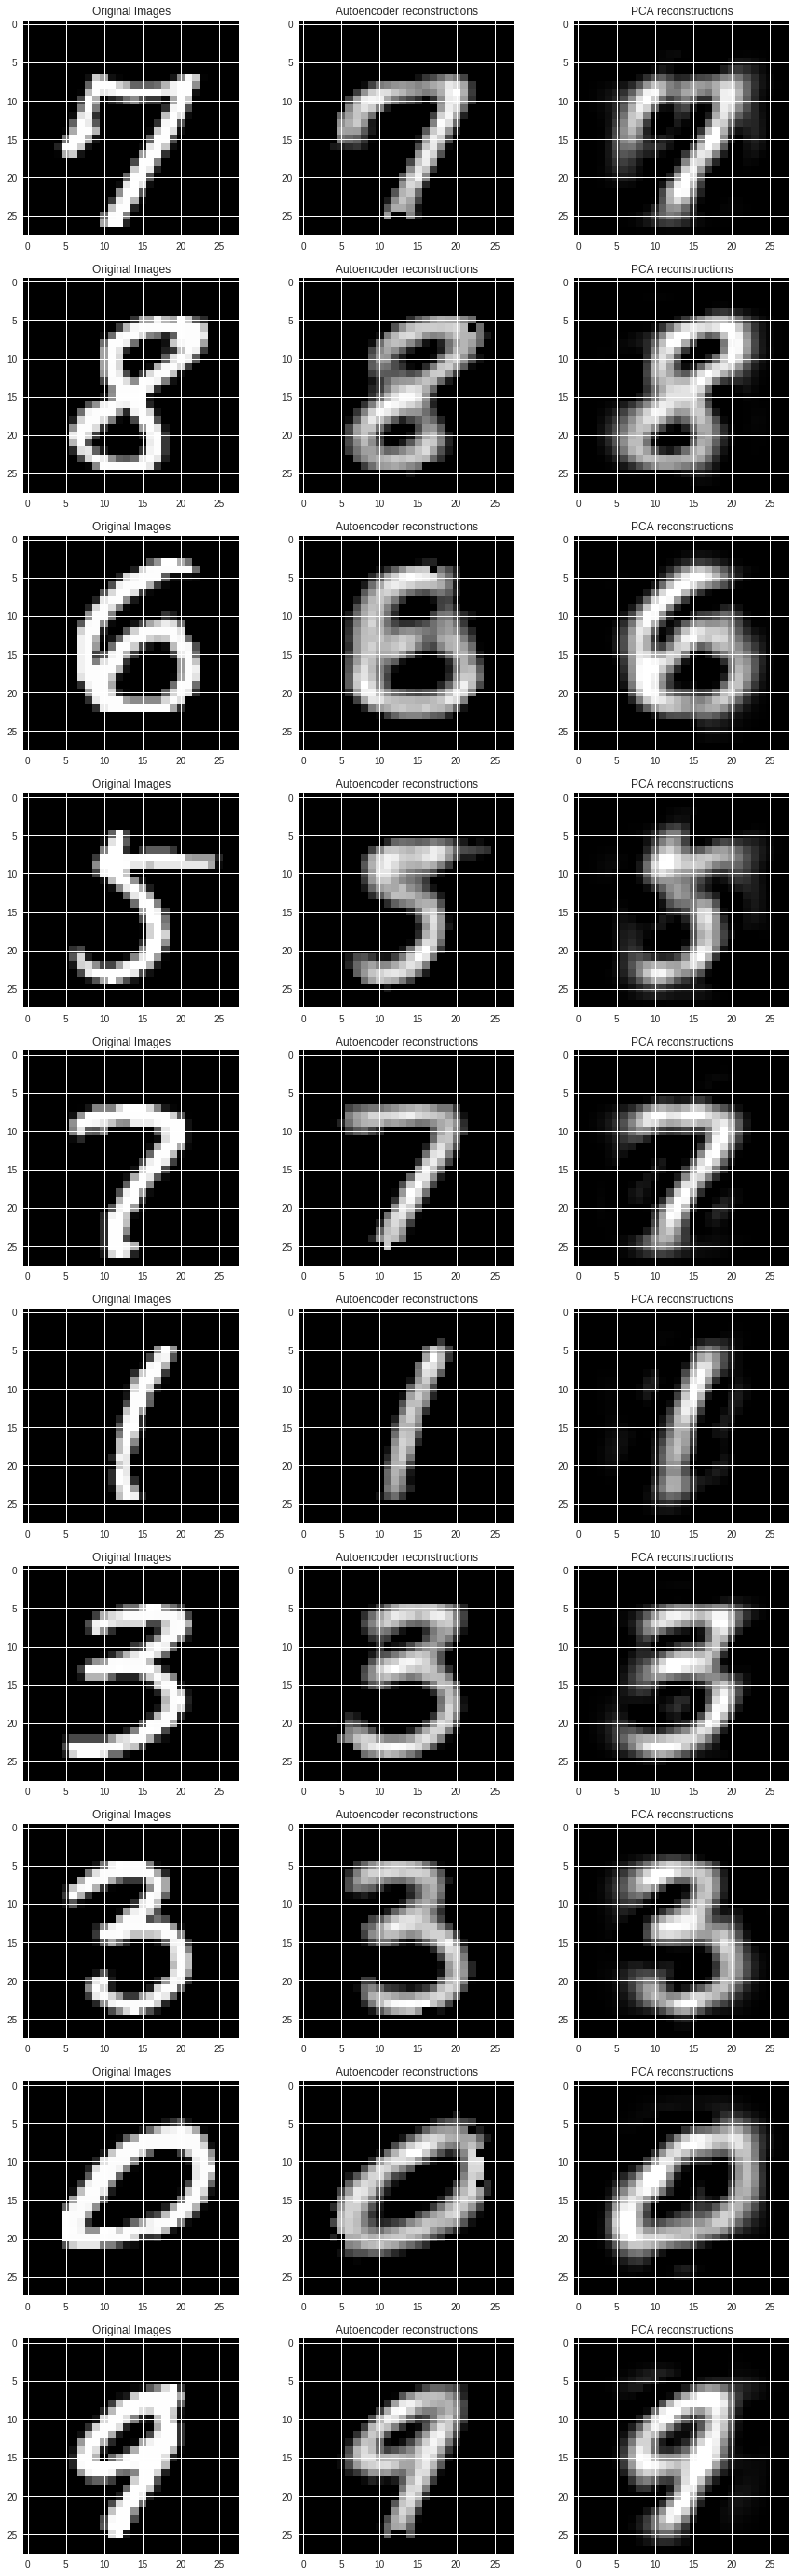

In [36]:
fig, ax = plt.subplots(10, 3, figsize=(15, 50))
for i in range(10):
    ax[i][0].set_title('Original Images')
    ax[i][0].imshow(X_test[i].reshape((28, 28)), cmap='gray')
    ax[i][1].set_title('Autoencoder reconstructions')
    ax[i][1].imshow(auto_pred[i].reshape((28, 28)), cmap='gray')
    ax[i][2].set_title('PCA reconstructions')
    ax[i][2].imshow(pca_pred[i].reshape((28, 28)), cmap='gray')

*Everything works great!*